In [18]:
import pandas as pd
df = pd.read_csv(r'C:\Users\Mouna\Desktop\Masters\Spring2019\Project Work\irma_coded_tweets.csv',dtype='str',encoding='utf-8',error_bad_lines=False,keep_default_na=False)
df['t']=df['tweet'].str.replace('http\S+|www.\S+', '', case=False)
df['t'] = df['t'].str.replace('@', ' ')
df['t'] = df['t'].str.replace('#', ' ')
df['t']=df['t'].str.lower()
from textblob import TextBlob
def split_into_lemmas(message):
    #message=message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]
df['t']=df['t'].apply(split_into_lemmas)

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stop = stopwords.words('english')
#stop.extend(('hurricaneirma','amp','irma','florida','hurrican'))
stemmer = SnowballStemmer("english")
df['t']=df['t'].apply(lambda x: [item for item in x if item not in stop])
df['t'] = df['t'].apply(lambda x: [stemmer.stem(y) for y in x])
df['len']=df['t'].str.len()
df.drop(df[df['len']<=2].index,inplace=True)
tweets = df['t'].tolist()
tweets = [[i for i in nested if len(i) > 2] for nested in tweets]

In [19]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora, models , similarities
import gensim
def bigrams(words, bi_min=10, tri_min=10):
    bigram = Phrases(words, min_count = bi_min)
    bigram_mod = Phraser(bigram)
    return bigram_mod
    
def get_corpus(df):
    words=df
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = corpora.Dictionary(bigram)
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

train_corpus, train_id2word, bigram_train = get_corpus(tweets)

In [20]:
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from xgboost import XGBClassifier
import numpy as np
def get_accuracies(start=20, limit=400, step=21):
    f1=[]
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamulticore.LdaMulticore(corpus=train_corpus, id2word=train_id2word, num_topics=num_topics)
        lda_vectors=[]
        for i in range(len(train_corpus)):
            top_topics=model.get_document_topics(train_corpus[i], minimum_probability=0.0)
            topic_vec = [top_topics[i][1] for i in range(num_topics)]
            lda_vectors.append(topic_vec)
        y=np.array(df.irma_rel)
        X=np.array(lda_vectors)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                        random_state=2,test_size=0.2)
        XGB_model = XGBClassifier(n_estimators=300, learning_rate=0.3)
        XGB_model.fit(Xtrain,ytrain)
        predictions = XGB_model.predict(Xtest)
        f1.append(f1_score(ytest, predictions,average='weighted'))
    return f1

C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gen

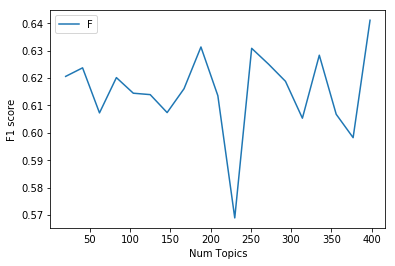

In [16]:
f1_values = get_accuracies(start=20, limit=400, step=21)
# Show graph
import matplotlib.pyplot as plt
limit=400; start=20; step=21;
x = range(start, limit, step)
plt.plot(x, f1_values)
plt.xlabel("Num Topics")
plt.ylabel("F1 score")
plt.legend(("F1_values"), loc='best')
plt.show()

In [21]:
#without removing hurricane
f1_scores = get_accuracies(start=20, limit=400, step=21)

C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
C:\Users\Mouna\Anaconda3\lib\site-packages\gen

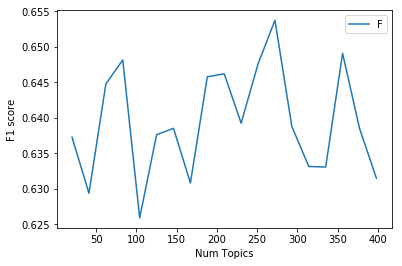

In [22]:
import matplotlib.pyplot as plt
limit=400; start=20; step=21;
x = range(start, limit, step)
plt.plot(x, f1_scores)
plt.xlabel("Num Topics")
plt.ylabel("F1 score")
plt.legend(("F1_values"), loc='best')
plt.show()